<a href="https://colab.research.google.com/github/victorviro/ML_algorithms_python/blob/master/Dimensionality_reduction_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimesionality reduction

Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution. This problem is often
referred to as the *curse of dimensionality*.

Fortunately, in real-world problems, it is often possible to reduce the number of features considerably, turning an intractable problem into a tractable one. 

**Note**: Reducing dimensionality does lose some information (just like compressing an image to JPEG can degrade its quality), so even though it will speed up training, it may also make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain. So you should first try to train your system with the original data before considering using dimensionality reduction if training is too slow. In some cases, however,
reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher performance (but in general it won’t; it will just speed up training).

Apart from speeding up training, dimensionality reduction is also extremely useful for data visualization (or *DataViz*). Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters. Moreover, DataViz is essential to communicate your conclusions to people who are not data scientists, in particular decision makers who will use your results.

![texto alternativo](https://i.ibb.co/zbMdmT7/c-d.png)

As shown in the figure, the dimension space increases exponentially when the dimension increased from $1$ to $2$ to $3$, the space accordingly increased from $10$ to $100$ to $1000$. For higher dimensions; hundreds, and millions, the situation will be more complex to visualize and manipulation.

We will discuss the curse of dimensionality and get a sense of what goes on in high-dimensional space. Then, we will present the two main approaches to dimensionality reduction (projection and Manifold Learning), and we will go through three of the most popular dimensionality reduction techniques: PCA, Kernel PCA, and LLE.

## The Curse of Dimensionality

We are so used to living in three dimensions that our intuition fails us when we try to imagine a high-dimensional space. Even a basic 4D hypercube is incredibly hard to picture in our mind (see Figure 8-1).

![texto alternativo](https://i.ibb.co/3rCZPG0/dimensionality.png)


It turns out that many things behave very differently in high-dimensional space. For example, if you pick a random point in a unit square (a $1 × 1$ square), it will have only about a $0.4%$ chance of being located less than $0.001$ from a border (it is very unlikely that a random point will be “extreme” along any dimension). But in a $10000$-dimensional unit hypercube (a $1 \times 1 \times ... \times 1$ cube, with ten thousand 1s), this probability is greater than $99.999999%$. Most points in a high-dimensional hypercube are very close to the border.

Here is a more troublesome difference: if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly $0.52$. If you pick two random points in a unit 3D cube, the average distance will be roughly $0.66$. But what about two points picked randomly in a $1000000$-dimensional hypercube? The average distance, believe it or not, will be about $408.25$. This is quite counterintuitive: how can two points be so far apart when they both lie within the same unit hypercube? This fact implies that high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other.


Of course, this also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions. In short, the more dimensions the training set has, the greater the risk of overfitting it.


In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just $100$ features, you would need more training instances than atoms in the observable universe in order for training instances to be within $0.1$ of each other on average, assuming they were spread out uniformly across all dimensions.



## Main Approaches for Dimensionality Reduction

Before we dive into specific dimensionality reduction algorithms, let’s take a look at the two main approaches to reducing dimensionality: projection and Manifold Learning.

### Projection

In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances actually lie within
(or close to) a much lower-dimensional subspace of the high-dimensional space. This sounds abstract, so let’s look at an example. In Figure 8-2 you can see a 3D dataset.

![texto alternativo](https://i.ibb.co/cJXsMHm/3d-to-2d.png)

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space. Now if we project every training instance perpendicularly onto this subspace (as represented by the short lines connecting the instances to the plane), we get the new 2D dataset shown in Figure 8-3.

![texto alternativo](https://i.ibb.co/Tv7Hb6T/2d-dataset.png)

We have just reduced the dataset’s dimensionality from 3D to 2D. Note that
the axes correspond to new features $z_1$ and $z_2$ (the coordinates of the projections on the plane).


However, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn, such as in the famous *Swiss roll* toy dataset represented in the next figure.



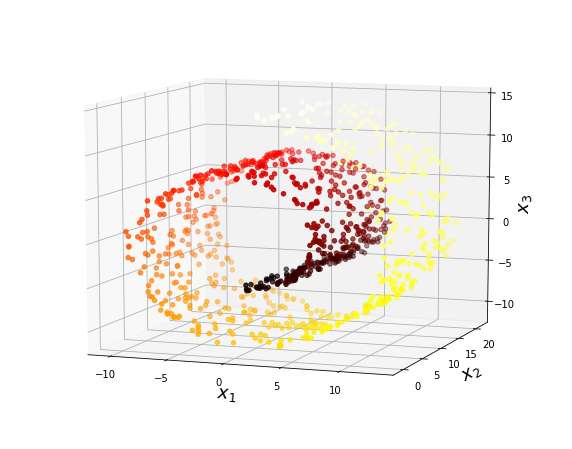

In [1]:
#@title
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.set_zlabel('$x_3$', fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

Simply projecting onto a plane (e.g., by dropping $x_3$ ) would squash different layers of the Swiss roll together, as shown on the left of the next figure. However, what you really want is to unroll the Swiss roll to obtain the 2D dataset on the right of the figure.


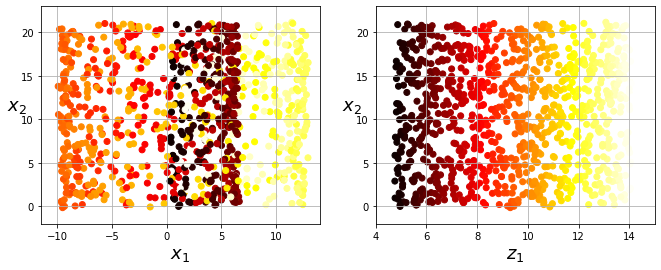

In [2]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

plt.figure(figsize=(11, 4))
plt.subplot(121) 
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)  # unroll
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.grid(True)
plt.show()

### Manifold Learning

The Swiss roll is an example of a 2D *manifold*. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a $d$-dimensional manifold is a part of an $n$-dimensional space (where $d < n$) that locally resembles a $d$-dimensional hyperplane. In the case of the Swiss roll, $d$ = 2 and $n$ = 3: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the *manifold* on which the training instances lie; this is called *Manifold Learning*. It relies on the manifold assumption, also called the *manifold hypothesis*, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

Think about the MNIST dataset:

![texto alternativo](https://miro.medium.com/max/1060/1*VAjYygFUinnygIx9eVCrQQ.png)

All handwritten digit images have some similarities. They are made of connected lines, the borders are white, they are more or less centered, and so on. If you randomly generated images, only a ridiculously tiny fraction of them would look like handwritten digits. In other words, the degrees
of freedom available to you if you try to create a digit image are dramatically lower than the degrees of freedom you would have if you were allowed to generate any image you wanted. These constraints tend to squeeze the dataset into a lower-dimensional manifold.

The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold. For example, in the top row of the next figure the Swiss roll is split into two classes: in the 3D space (on the left), the decision boundary would be fairly complex, but in the 2D unrolled manifold space (on the right), the decision boundary is a simple straight line.





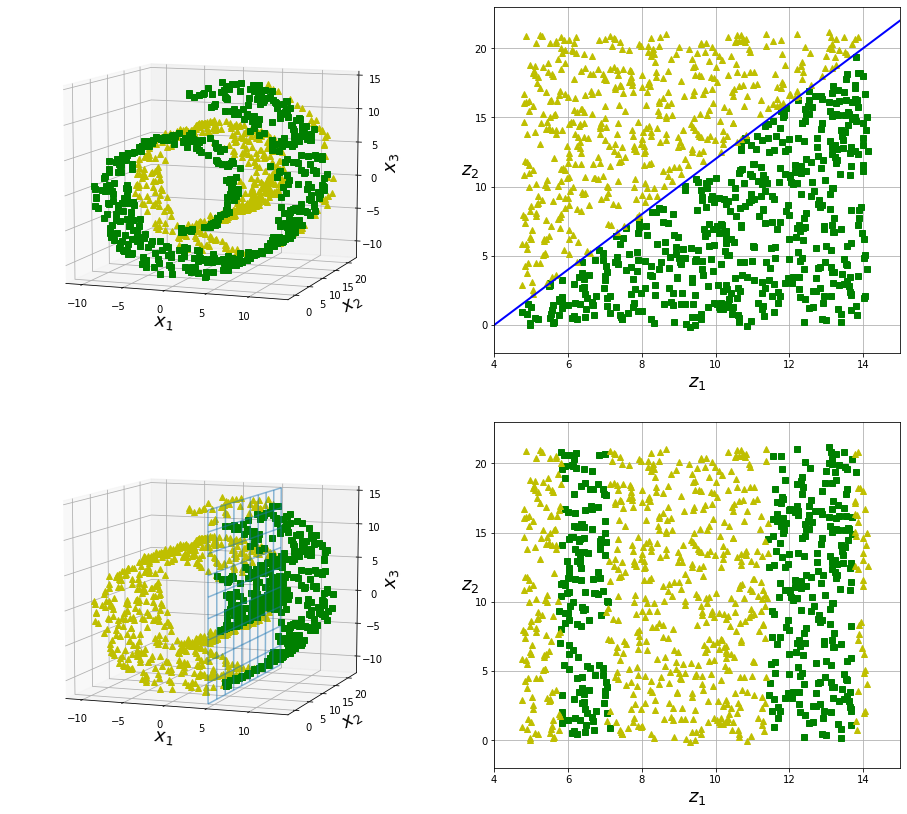

In [3]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(16, 14))
ax = plt.subplot(221, projection='3d')
positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]

ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], 'y^')
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], 'gs')
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.set_zlabel('$x_3$', fontsize=18)
ax.set_xlim(axes[:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:])

ax = plt.subplot(222)
plt.plot(t[positive_class], X[positive_class, 1], 'gs')
plt.plot(t[~positive_class], X[~positive_class, 1], 'y^')
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)


positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]

ax = plt.subplot(223, projection='3d')

x2s = np.linspace(axes[2], axes[3], 10) 
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], 'y^')
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], 'gs')
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.set_zlabel('$x_3$', fontsize=18)
ax.set_xlim(axes[:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:])

ax = plt.subplot(224)
plt.plot(t[positive_class], X[positive_class, 1], 'gs')
plt.plot(t[~positive_class], X[~positive_class, 1], 'y^')
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)
plt.show()

However, this assumption does not always hold. For example, in the bottom row of the previous figure , the decision boundary is located at $x_1 = 5$. This decision boundary looks very simple in the original 3D space (a vertical plane), but it looks more complex in the unrolled manifold (a collection of four independent line segments).

In short, if you reduce the dimensionality of your training set before training a model, it will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

Hopefully you now have a good sense of what the curse of dimensionality is and how dimensionality reduction algorithms can fight it, especially when the manifold assumption holds. The rest of this article will go through some of the most popular algorithms.

## PCA

*Principal Component Analysis* (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it, just like in Figure 8-2.

### Preserving the variance

Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. For example, a simple 2D dataset is represented on the left of Figure 8-7, along with three different axes (i.e., one-dimensional hyperplanes). On the right is the result of the projection of the dataset onto each of these axes.

![texto alternativo](https://i.ibb.co/SyydJqh/variance-projection.png)

As you can see, the projection onto the solid line preserves the maximum
variance, while the projection onto the dotted line preserves very little variance, and the projection onto the dashed line preserves an intermediate amount of variance.


It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.


### Principal components

PCA identifies the axis that accounts for the largest amount of variance in the training set. In Figure 8-7, it is the solid line. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. In this 2D example there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on, as many axes as the number of dimensions in the dataset.

The unit vector that defines the $i^{\text{th}}$ axis is called the $i^{\text{th}}$ *principal component* (PC). In Figure 8-7, the first PC is $c_1$ and thesecond PC is $c_2$ . In Figure 8-2 the first two PCs are represented by the orthogonal arrows in the plane, and the third PC would be orthogonal to the plane (pointing up or down). The principal components are uncorrelated with each other.

**Note**: The direction of the principal components is not stable: if you perturb the training set slightly and run PCA again, some of the new PCs may point in the opposite direction of the original PCs. However, they will generally still lie on the same axes. In some cases, a pair of PCs may even rotate or swap, but the plane they define will generally remain the same.

So how can you find the principal components of a training set? Getting the principal components requires to scale the dataset and computes the eigenvectors and corresponding eigenvalues of the covariance matrix of the whole dataset. Luckily, there is a standard matrix factorization technique called *Singular Value Decomposition* (SVD) that can decompose the training set matrix $\boldsymbol{X}$ into the matrix multiplication of three matrices $\boldsymbol{U}\Sigma\boldsymbol{V}$ , where $\boldsymbol{V}$ contains all the principal components that we are looking for.

You can use NumPy’s `svd()` function to obtain all the principal components of the training set, then extracts the first PCs you want. Alternatively, you can use Scikit-Learn’s `PCA` class as we will see later. 

**Note**: PCA assumes that the dataset is centered around the origin. As we
will see, Scikit-Learn’s `PCA` classes take care of centering the data
for you. However, if you implement PCA yourself (as in the pre‐
ceding example), don’t forget to center the data first.

### Projecting down to $d$ dimensions

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible. For example, in Figure 8-2 the 3D dataset is projected down to the 2D plane defined by the first two principal components, preserving a large part of the dataset’s variance. As a result, the 2D projection looks very much like the original 3D dataset.

To project the training set onto the hyperplane, you can simply compute the matrix multiplication of the training set matrix $\boldsymbol{X}$ by the matrix $\boldsymbol{W}_d$ , defined as the matrix containing the first $d$ principal components (i.e., the matrix composed of the first $d$ columns of $\boldsymbol{V}$), as shown in the next equation.

$$\boldsymbol{X}_{d\text{-proj}}=\boldsymbol{X}\boldsymbol{W}_d$$


### In Scikit-Learn

Scikit-Learn’s `PCA` class implements PCA using SVD decomposition. The following code applies PCA to reduce the dimensionality of the MNIST dataset down to 100 dimensions (note that it automatically takes care of centering the data):

In [4]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape)
pca = PCA(n_components = 100)
X100D = pca.fit_transform(X)
print(X100D.shape)

(70000, 784)
(70000, 100)


After fitting the PCA transformer to the dataset, you can access the principal components using the `components_` variable (note that it contains the PCs as horizontal vectors, so, for example, the first principal component is equal to `pca.components_.T[:,0]`).

### Explained Variance Ratio

Another very useful piece of information is the *explained variance ratio* of each principal component, available via the `explained_variance_ratio_` variable. It indicates the proportion of the dataset’s variance that lies along the axis of each principal component. For example, the explained variance ratios of the first two components of the 3D dataset represented in Figure 8-2 are `[0.84248607, 0.14631839]`. This tells you that $84.2$% of the dataset’s variance lies along the first axis, and $14.6$% lies along the second axis. This leaves less than $1.2$% for the third axis, so it is reasonable to assume that it probably carries little information.

### Choosing the right number of dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., $95$%). Unless, of course, you are reducing dimensionality for data visualization—in that case you will generally want to reduce the dimensionality down to $2$ or $3$.

The following code computes PCA in the MNIST dataset without reducing dimensionality, then computes the minimum number of dimensions required to preserve $95$% of the training set’s variance:

In [5]:
import numpy as np

pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

154


You could then set `n_components=d` and run PCA again. However, there is a much better option: instead of specifying the number of principal components you want to preserve, you can set `n_components` to be a float between $0.0$ and $1.0$ , indicating the ratio of variance you wish to preserve:

In [6]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
print(X_reduced.shape)

(70000, 154)


Yet another option is to plot the explained variance as a function of the number of dimensions. There will usually be an elbow in the curve, where the explained variance stops growing fast. You can think of this as the intrinsic dimensionality of the dataset. In this case, you can see that reducing the dimensionality down to about $154$ dimensions wouldn’t lose too much explained variance.

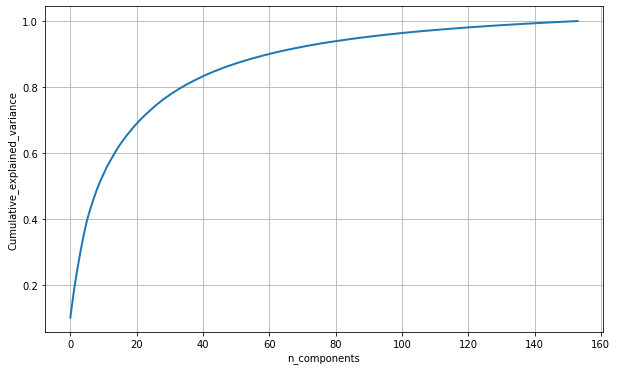

In [7]:
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

import matplotlib.pyplot as plt

plt.figure(1, figsize=(10, 6))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

### PCA for Compression

Obviously after dimensionality reduction, the training set takes up much less space. For example, applying PCA to the MNIST dataset while preserving $95$% of its variance we find that each instance will have just over $155$ features, instead of the original $784$ features. So while most of the variance is preserved, the dataset is now less than $20$% of its original size! This is a reasonable compression ratio, and you can see how this can speed up a classification algorithm (such as an SVM classifier) tremendously.


It is also possible to decompress the reduced dataset back to $784$ dimensions by applying the inverse transformation of the PCA projection. Of course this won’t give you back the original data, since the projection lost a bit of information, but it will likely be quite close to the original data.
The mean squared distance between the original data and the reconstructed data
(compressed and then decompressed) is called the *reconstruction error*. For example, the following code compresses the MNIST dataset down to $154$ dimensions, then uses the `inverse_transform()` method to decompress it back to $784$ dimensions.


In [8]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)
print(X_recovered.shape)

(70000, 784)


Figure 8-9 shows a few digits from the original training set (on the left), and the corresponding digits after compression and decompression. You can see that there is a slight image quality loss, but the digits are still mostly intact.

![texto alternativo](https://i.ibb.co/YNfHyhH/mnist-compression.png)

The equation of the inverse transformation is:

$$\boldsymbol{X}_{\text{recovered}}=\boldsymbol{X}_{d\text{proj}}\boldsymbol{W}_d^T$$

### Randomized PCA

If you set the `svd_solver` hyperparameter to "`randomized`" , Scikit-Learn uses a stochastic algorithm called *Randomized* PCA that quickly finds an approximation of the first $d$ principal components. Its computational complexity is $O(m \times d^2) + O(d^3)$, instead of $O(m \times n^2) + O(n^3)$ for the full SVD approach, so it is dramatically faster than full SVD when $d$ is much smaller than $n$:



In [9]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X)
print(X_reduced.shape)


(70000, 154)


By default, `svd_solver` is actually set to "`auto`" : Scikit-Learn automatically uses the randomized PCA algorithm if $m$ or $n$ is greater than $500$ and $d$ is less than $80$% of $m$ or $n$, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the `svd_solver` hyperparameter to "`full`" .

### Incremental PCA

One problem with the preceding implementations of PCA is that they require the
whole training set to fit in memory in order for the algorithm to run. Fortunately, *Incremental* PCA (IPCA) algorithms have been developed: you can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets, and also to apply PCA online (i.e., on the fly, as new instances arrive).

The following code splits the MNIST dataset into $100$ mini-batches (using NumPy’s `array_split()` function) and feeds them to Scikit-Learn’s [`IncrementalPCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html) class to reduce the dimensionality of the MNIST dataset down to $154$ dimensions (just like before). Note that you must call the `partial_fit()` method with each mini-batch rather than the `fit()` method with the whole training set:

In [10]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X)
print(X_reduced.shape)

(70000, 154)


Alternatively, you can use NumPy’s `memmap` class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. Since the `IncrementalPCA` class uses only a small part of the array at any given time, the memory usage remains under control. This makes it possible to call the usual `fit()` method, as you can see in the following code:



```
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)
```



## Kernel PCA

In this [notebook](https://github.com/victorviro/ML_algorithms_python/blob/master/Support_Vector_Machines_explained.ipynb) we discussed the kernel trick, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the *feature space*), enabling nonlinear classification and regression with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the *original space*.

It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called [Kernel PCA (kPCA)](https://people.eecs.berkeley.edu/~wainwrig/stat241b/scholkopf_kernel.pdf). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

For example, the following code uses Scikit-Learn’s `KernelPCA` class to perform kPCA in the Swiss roll dataset, reducing to two dimensions using an RBF kernel:





In [11]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)
print(X_reduced.shape) 

(1000, 2)


The next figure shows the Swiss roll, reduced to two dimensions using a linear kernel (equivalent to simply using the `PCA` class), an RBF kernel, and a sigmoid kernel (Logistic).


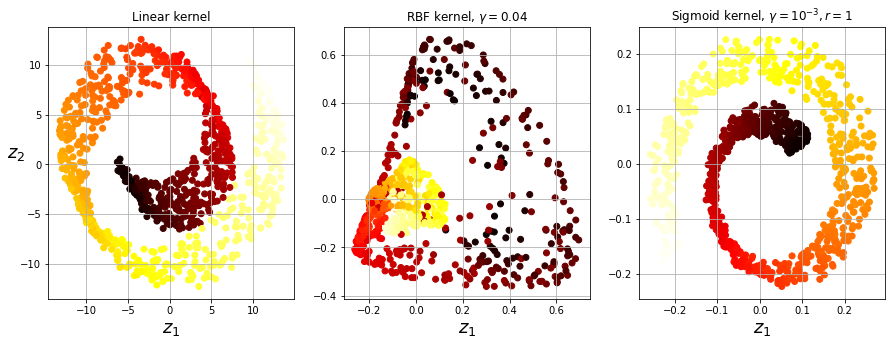

In [12]:
#@title
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)

plt.figure(figsize=(15, 5))
for subplot, pca, title in ((131, lin_pca, 'Linear kernel'), (132, rbf_pca, 'RBF kernel, $\gamma = 0.04$'), (133, sig_pca, 'Sigmoid kernel, $\gamma=10^{-3}, r=1$')):
    X_reduced = pca.fit_transform(X)
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
plt.show()

### Selecting a Kernel and Tuning Hyperparameters

As kPCA is an unsupervised learning algorithm, there is no obvious performance
measure to help you select the best kernel and hyperparameter values. However,
dimensionality reduction is often a preparation step for a supervised learning task (e.g., classification), so you can simply use grid search to select the kernel and hyperparameters that lead to the best performance on that task. For example, the following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA, then applying Logistic Regression for classification. Then it uses `GridSearchCV` to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [13]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(solver='liblinear'))  
])

param_gird = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]
# If no scoring is specified, the estimator passed should have a 'score' method.
grid_search = GridSearchCV(clf, param_gird, cv=3)
grid_search.fit(X, y)

# The best kernel and hyperparameters 
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Another approach, this time entirely unsupervised, is to select the kernel and hyperparameters that yield the lowest reconstruction error. However, reconstruction is not as easy as with linear PCA (recall that the reconstruction error is the mean squared distance between the original data and the reconstructed data in a linear PCA). Here’s why. Figure 8-11 shows the original Swiss roll 3D dataset (top left), and the resulting 2D dataset after kPCA is applied using an RBF kernel (top right).

Thanks to the kernel trick, this is mathematically equivalent to mapping the training set to an infinite-dimensional feature space (bottom right) using the *feature map* $\phi$, then projecting the transformed training set down to 2D
using linear PCA. Notice that if we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in feature space, not in the original space (e.g., like the one represented by an x in the diagram). Since the feature space is infinite-dimensional, we cannot compute the reconstructed point, and therefore we cannot compute the true reconstruction error. Fortunately, it is possible to find a point in the original space that would map close to the reconstructed point. This is called the reconstruction *pre-image*. Once you have this pre-image, you
can measure its squared distance to the original instance. You can then select the kernel and hyperparameters that minimize this reconstruction pre-image error.

![texto alternativo](https://i.ibb.co/N96dKbh/k-PCA-pre-image-reconstruction.png)

You may be wondering how to perform this reconstruction. One solution is to train a supervised regression model, with the projected instances as the training set and the original instances as the targets. Scikit-Learn will do this automatically if you set `fit_inverse_transform=True` , as shown in the following code:

In [14]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.043, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)


**Note**: By default, `fit_inverse_transform=False` and KernelPCA has no
`inverse_transform()` method. This method only gets created when you set `fit_inverse_transform=True`.

You can then compute the reconstruction pre-image error:

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.70536352954472

Now you can use grid search with cross-validation to find the kernel and hyperparameters that minimize this pre-image reconstruction error.

## LLE

*Locally Linear Embedding* (LLE) is another very powerful *nonlinear dimensionality reduction* (NLDR) technique. It is a Manifold Learning technique that does not rely on projections like the previous algorithms. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved. This makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

For example, the following code uses Scikit-Learn’s LocallyLinearEmbedding class to unroll the Swiss roll. The resulting 2D dataset is shown in next figure. As you can see, the Swiss roll is completely unrolled and the distances between instances are locally well preserved. However, distances are not preserved on a larger scale: the left part of the unrolled Swiss roll is stretched, while the right part is squeezed. Nevertheless, LLE did a pretty good job at modeling the manifold.

In [16]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
y = t > 6.9

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)
print(X_reduced.shape)  # (1000, 2)

(1000, 2)


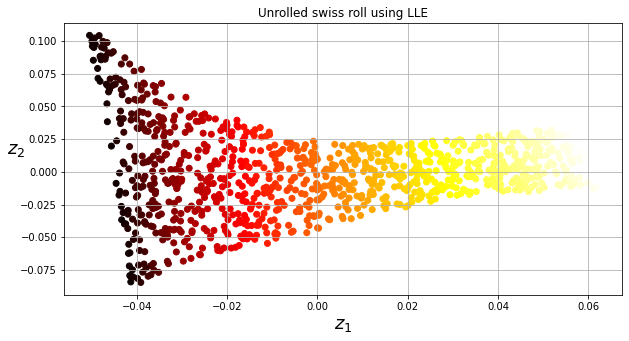

In [17]:
#@title
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title('Unrolled swiss roll using LLE')
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()


Here’s how LLE works: first, for each training instance $\boldsymbol{x}^{(i)}$, the algorithm identifies its $k$ closest neighbors (in the preceding code `n_neighbors=10`), then tries to reconstruct $\boldsymbol{x}^{(i)}$ as a linear function of these neighbors. More specifically, it finds the weights $w_{i,j}$ such that the squared distance between $\boldsymbol{x}^{(i)}$ and
$\sum_{j=1}^{m}w_{i,j}\boldsymbol{x}^{(j)}$ as small as possible, assuming $w_{i,j}=0$ if $\boldsymbol{x}^{(j)}$ is not one of the $k$ closest neighbors of $\boldsymbol{x}^{(i)}$. Thus the first step of LLE is the constrained optimization problem described in the next equation:

$$\hat{\boldsymbol{W}}=\text{arg}\min\limits_{\boldsymbol{W}}\sum_{i=1}^{m}(\boldsymbol{x}^{(i)}-\sum_{j=1}^{m}w_{i,j}\boldsymbol{x}^{(j)})^2$$

subject to

$$
     \begin{cases}
              w_{i,j}=0 & \text{if } \boldsymbol{x}^{(i)} \text{ is not one of the c.n of } \boldsymbol{x}^{(i)},\\
               \sum_{j=1}^{m}w_{i,j}=1 & \text{for } i=1,2,...,m.
     \end{cases}
$$


- $\hat{\boldsymbol{W}}$ is the weight matrix containing all the weights $\hat{w}_{i,j}$. 


- The second constraint simply normalizes the weights for each training instance $\boldsymbol{x}^{(i)}$.


After this step, the weight matrix $\hat{\boldsymbol{W}}$ encodes the local
linear relationships between the training instances. Now the second step is to map the training instances into a $d$-dimensional space (where $d < n$) while preserving these local relationships as much as possible. If $\boldsymbol{z}^{(i)}$ is the image of $\boldsymbol{x}^{(i)}$ in this $d$-dimensional space, then we want the squared distance between $\boldsymbol{z}^{(i)}$ and $\sum_{j=1}^{m}\hat{w}_{i,j}\boldsymbol{z}^{(j)}$ to be as small as possible. This idea leads to the unconstrained optimization problem described in the next equation.

$$\hat{\boldsymbol{Z}}=\text{arg}\min\limits_{\boldsymbol{Z}}\sum_{i=1}^{m}(\boldsymbol{z}^{(i)}-\sum_{j=1}^{m}\hat{w}_{i,j}\boldsymbol{z}^{(j)})^2$$

It looks very similar to the first step, but instead of keeping the instances fixed and finding the optimal weights, we are doing the reverse: keeping the
weights fixed and finding the optimal position of the instances’ images in the low-dimensional space. Note that $\boldsymbol{Z}$ is the matrix containing all $\boldsymbol{z}^{(i)}$.

Scikit-Learn’s `LLE` implementation has the following computational complexity: $O(m\times log(m)\times n \times log(k))$ for finding the $k$ nearest neighbors, $O(m\times n\times k^3)$ for optimizing the weights, and $O(d\times m^2)$ for constructing the low-dimensional representations. Unfortunately, the $m^2$ in the last term makes this algorithm scale poorly to very large datasets.


## Other Dimensionality Reduction Techniques

There are other dimensionality reduction techniques, several of which are
available in Scikit-Learn. Here are some of the most popular:

- *Multidimensional Scaling* (MDS) reduces dimensionality while trying to preserve the distances between the instances.

- *Isomap* creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the *geodesic distances* between the instances. The geodesic distance between two nodes in a graph is the number of nodes on the shortest path between these nodes.


- *t-Distributed Stochastic Neighbor Embedding* (t-SNE) reduces dimensionality
while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).

- *Linear Discriminant Analysis* (LDA) is actually a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.

In [18]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(
    n_samples=1000, 
    noise=0.2, 
    random_state=41)

from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(X)



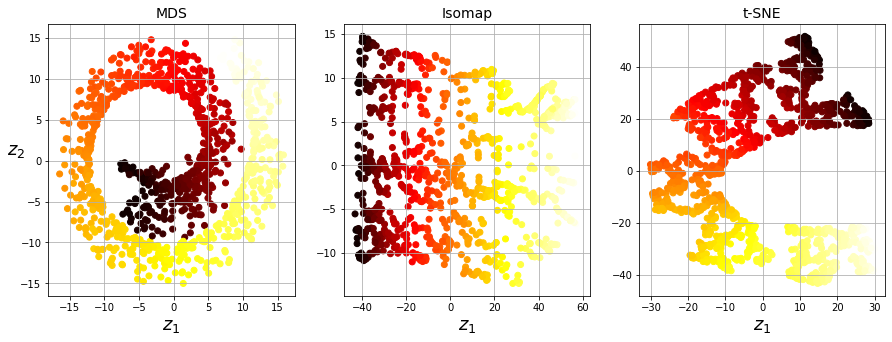

In [19]:
#@title
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(15,5))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()